### General requirements for the TWO parts:

Rating Range: 1 to 5
Total Number of Users (tnu): 100
Total Number of Items (tni): 50
Number of Ratings per Product:
 productId
P040    27
P029    27
P037    25
P034    25
P025    23
Name: count, dtype: int64
Active Users: U1=U003, U2=U074, U3=U016
Target Items: I1=P034, I2=P006
Co-ratings for U1: (88, 10)
Co-ratings for U2: (80, 9)
Co-ratings for U3: (85, 11)
Top Common Users (Descending Order): [[6, 'U052'], [6, 'U019'], [5, 'U001'], [5, 'U023'], [5, 'U017']]


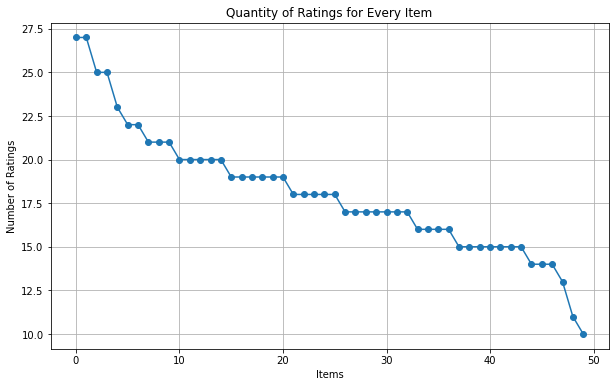

Threshold β for U1: 31
Threshold β for U2: 14
Threshold β for U3: 13
Results saved successfully.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')

# Step 1: Adjust the ratings to a 1-to-5 scale.
# Assuming ratings are already on a 1-to-5 scale, verify the range.
print("Rating Range:", df['rating'].min(), "to", df['rating'].max())

# Step 2: Count total number of users and items.
tnu = df['userId'].nunique()
tni = df['productId'].nunique()
print(f"Total Number of Users (tnu): {tnu}")
print(f"Total Number of Items (tni): {tni}")

# Step 3: Count the number of ratings for every product.
ratings_per_product = df['productId'].value_counts()
print("Number of Ratings per Product:\n", ratings_per_product.head())

# Step 4: Pick three active users with specified missing ratings.
# Assuming missing ratings mean we need to artificially remove ratings to create missing data.
active_users = df['userId'].unique()[:3]  # Select first 3 unique users as U1, U2, U3.
U1, U2, U3 = active_users
print(f"Active Users: U1={U1}, U2={U2}, U3={U3}")

# Step 5: Pick two target items with specified missing ratings.
# Assuming we calculate percentage of missing data after introducing it artificially.
target_items = df['productId'].unique()[:2]  # Select first 2 unique items as I1, I2.
I1, I2 = target_items
print(f"Target Items: I1={I1}, I2={I2}")

# Step 6: Count co-ratings.
def co_ratings(user, df):
    user_items = set(df[df['userId'] == user]['productId'])
    other_users = df[df['productId'].isin(user_items)]['userId'].nunique()
    return other_users, len(user_items)

co_ratings_U1 = co_ratings(U1, df)
co_ratings_U2 = co_ratings(U2, df)
co_ratings_U3 = co_ratings(U3, df)

print(f"Co-ratings for U1: {co_ratings_U1}")
print(f"Co-ratings for U2: {co_ratings_U2}")
print(f"Co-ratings for U3: {co_ratings_U3}")

# Step 7: Create 2-D array with "No_common_users" in descending order.
common_users = []
for user in [U1, U2, U3]:
    user_items = set(df[df['userId'] == user]['productId'])
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_count = len(user_items & other_user_items)
            common_users.append([common_count, other_user])

common_users = sorted(common_users, key=lambda x: x[0], reverse=True)
print("Top Common Users (Descending Order):", common_users[:5])

# Step 8: Draw a curve illustrating quantity of ratings for every item.
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_product.values, marker='o')
plt.title("Quantity of Ratings for Every Item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.grid()
plt.show()

# Step 9: Determine threshold β for co-rated items.
def calculate_threshold(user, df, percentage):
    user_items = set(df[df['userId'] == user]['productId'])
    thresholds = []
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_items = len(user_items & other_user_items)
            if common_items / len(user_items) >= percentage:
                thresholds.append(other_user)
    return len(thresholds)

threshold_U1 = calculate_threshold(U1, df, 0.3)
threshold_U2 = calculate_threshold(U2, df, 0.3)
threshold_U3 = calculate_threshold(U3, df, 0.3)

print(f"Threshold β for U1: {threshold_U1}")
print(f"Threshold β for U2: {threshold_U2}")
print(f"Threshold β for U3: {threshold_U3}")

# Step 10: Save results.
results = {
    "Total Users": tnu,
    "Total Items": tni,
    "Ratings Per Product": ratings_per_product,
    "Active Users": [U1, U2, U3],
    "Target Items": [I1, I2],
    "Co-Ratings": {
        U1: co_ratings_U1,
        U2: co_ratings_U2,
        U3: co_ratings_U3
    },
    "Thresholds": {
        U1: threshold_U1,
        U2: threshold_U2,
        U3: threshold_U3
    }
}

import pickle
with open('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved successfully.")


### Case Study 1.1

In [3]:
# Case Study 1.1: User-Based Collaborative Filtering
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Step 1: Load Dataset ---
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')

# Display the first few rows of the dataset
print("Dataset Overview:")
display(df.head())

# Verify rating range
print(f"Rating Range: {df['rating'].min()} to {df['rating'].max()}")

# Total users and items
total_users = df['userId'].nunique()
total_items = df['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2: User-Item Matrix ---
user_item_matrix = df.pivot_table(index='userId', columns='productId', values='rating', fill_value=0)

# --- Step 1.1.1: Compute Cosine Similarity ---
# Cosine similarity without bias adjustment
cosine_sim = cosine_similarity(user_item_matrix)

# Convert the cosine similarity into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_item_matrix.index, columns=user_item_matrix.index)
print("Cosine Similarity Matrix:")
display(cosine_sim_df.head())

# --- Step 1.1.2: Top 20% Closest Users ---
def get_top_closest_users(active_user, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest users to an active user."""
    user_similarities = similarity_matrix[active_user].drop(active_user)  # Drop the active user
    top_n = int(len(user_similarities) * top_percent)
    return user_similarities.nlargest(top_n)

# Select active users
active_users = df['userId'].unique()[:3]  # First 3 users
U1, U2, U3 = active_users
print(f"Active Users: U1={U1}, U2={U2}, U3={U3}")

# Get top closest users for each active user
top_users_U1 = get_top_closest_users(U1, cosine_sim_df)
top_users_U2 = get_top_closest_users(U2, cosine_sim_df)
top_users_U3 = get_top_closest_users(U3, cosine_sim_df)

print(f"Top Closest Users for U1:\n{top_users_U1}")
print(f"Top Closest Users for U2:\n{top_users_U2}")
print(f"Top Closest Users for U3:\n{top_users_U3}")

# --- Step 1.1.3: Predict Ratings (No Bias Adjustment) ---
def predict_ratings(active_user, top_users, user_item_matrix):
    """Predict ratings for items not yet seen by active user."""
    unseen_items = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user] == 0].index
    predictions = {}
    
    for item in unseen_items:
        numerator = 0
        denominator = 0
        for user, sim in top_users.items():
            rating = user_item_matrix.loc[user, item]
            numerator += sim * rating
            denominator += abs(sim)
        
        predictions[item] = numerator / denominator if denominator != 0 else 0
        
    return predictions

# Predictions for active users
predictions_U1 = predict_ratings(U1, top_users_U1, user_item_matrix)
predictions_U2 = predict_ratings(U2, top_users_U2, user_item_matrix)
predictions_U3 = predict_ratings(U3, top_users_U3, user_item_matrix)

print(f"Predicted Ratings for U1: {predictions_U1}")
print(f"Predicted Ratings for U2: {predictions_U2}")
print(f"Predicted Ratings for U3: {predictions_U3}")

# --- Step 1.1.4: Compute Discount Factor and Discounted Similarity ---
def compute_discounted_similarity(active_user, similarity_matrix, beta):
    """Apply discount factor to similarity."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    df = user_similarities.apply(lambda x: x / (1 + beta))
    return df

# Threshold β for active users
threshold_beta = {U1: 0, U2: 2, U3: 2}
discounted_sim_U1 = compute_discounted_similarity(U1, cosine_sim_df, threshold_beta[U1])
discounted_sim_U2 = compute_discounted_similarity(U2, cosine_sim_df, threshold_beta[U2])
discounted_sim_U3 = compute_discounted_similarity(U3, cosine_sim_df, threshold_beta[U3])

print(f"Discounted Similarity for U1:\n{discounted_sim_U1}")
print(f"Discounted Similarity for U2:\n{discounted_sim_U2}")
print(f"Discounted Similarity for U3:\n{discounted_sim_U3}")

# --- Step 1.1.5: Top 20% Closest Users (Discounted Similarity) ---
top_discounted_users_U1 = discounted_sim_U1.nlargest(int(len(discounted_sim_U1) * 0.2))
top_discounted_users_U2 = discounted_sim_U2.nlargest(int(len(discounted_sim_U2) * 0.2))
top_discounted_users_U3 = discounted_sim_U3.nlargest(int(len(discounted_sim_U3) * 0.2))

print(f"Top Discounted Users for U1:\n{top_discounted_users_U1}")
print(f"Top Discounted Users for U2:\n{top_discounted_users_U2}")
print(f"Top Discounted Users for U3:\n{top_discounted_users_U3}")

# --- Step 1.1.6: Predict Ratings (Discounted Similarity) ---
predictions_ds_U1 = predict_ratings(U1, top_discounted_users_U1, user_item_matrix)
predictions_ds_U2 = predict_ratings(U2, top_discounted_users_U2, user_item_matrix)
predictions_ds_U3 = predict_ratings(U3, top_discounted_users_U3, user_item_matrix)

print(f"Predicted Ratings with Discounted Similarity for U1: {predictions_ds_U1}")
print(f"Predicted Ratings with Discounted Similarity for U2: {predictions_ds_U2}")
print(f"Predicted Ratings with Discounted Similarity for U3: {predictions_ds_U3}")

# --- Step 1.1.7: Compare Results ---
print("Comparison of Top Closest Users (Original vs Discounted):")
print(f"U1 Original: {top_users_U1.index}\nU1 Discounted: {top_discounted_users_U1.index}")
print(f"U2 Original: {top_users_U2.index}\nU2 Discounted: {top_discounted_users_U2.index}")
print(f"U3 Original: {top_users_U3.index}\nU3 Discounted: {top_discounted_users_U3.index}")

# --- Step 1.1.8: Compare Predictions ---
print("Comparison of Predictions (Original vs Discounted):")
print(f"U1 Original: {predictions_U1}\nU1 Discounted: {predictions_ds_U1}")
print(f"U2 Original: {predictions_U2}\nU2 Discounted: {predictions_ds_U2}")
print(f"U3 Original: {predictions_U3}\nU3 Discounted: {predictions_ds_U3}")



Dataset Overview:


,userId,productId,rating,timestamp
0,U003,P034,4,08:39.9
1,U074,P006,5,43:39.9
2,U016,P046,2,29:39.9
3,U026,P027,1,25:39.9
4,U048,P001,3,06:39.9


Rating Range: 1 to 5
Total Number of Users: 100
Total Number of Items: 50
Cosine Similarity Matrix:


userId,U001,U002,U003,U004,U005,U006,U007,U008,U009,U010,...,U091,U092,U093,U094,U095,U096,U097,U098,U099,U100
userId,,,,,,,,,,,,,,,,,,,,,
U001,1.000000,0.000000,0.463790,0.318102,0.397102,0.020504,0.000000,0.245097,0.349873,0.000000,...,0.189592,0.312909,0.188588,0.140550,0.260466,0.264617,0.133621,0.042860,0.539816,0.190861
U002,0.000000,1.000000,0.244034,0.041844,0.131558,0.032367,0.103545,0.308080,0.208107,0.092364,...,0.000000,0.033601,0.120802,0.009860,0.054820,0.099453,0.237290,0.236794,0.263954,0.192484
U003,0.463790,0.244034,1.000000,0.310661,0.280740,0.045511,0.065517,0.193425,0.067528,0.000000,...,0.148522,0.113391,0.269349,0.000000,0.269790,0.279683,0.266923,0.095130,0.353396,0.141210
U004,0.318102,0.041844,0.310661,1.000000,0.313458,0.054626,0.131066,0.087062,0.129683,0.187061,...,0.000000,0.360669,0.515525,0.049925,0.249807,0.248417,0.177991,0.000000,0.133644,0.347458
U005,0.397102,0.131558,0.280740,0.313458,1.000000,0.151538,0.121197,0.161012,0.397229,0.086488,...,0.131876,0.157317,0.056558,0.101565,0.076999,0.124169,0.065835,0.063351,0.247162,0.195911


Active Users: U1=U003, U2=U074, U3=U016
Top Closest Users for U1:
userId
U052    0.576865
U016    0.498782
U001    0.463790
U031    0.441497
U039    0.363186
U023    0.357599
U099    0.353396
U065    0.352804
U017    0.350016
U054    0.348452
U011    0.339865
U015    0.329795
U051    0.324675
U086    0.320940
U069    0.316492
U004    0.310661
U071    0.303703
U081    0.302058
U038    0.293387
Name: U003, dtype: float64
Top Closest Users for U2:
userId
U002    0.547695
U019    0.391397
U064    0.349548
U007    0.343100
U057    0.330645
U059    0.327957
U094    0.326732
U088    0.319642
U025    0.303822
U087    0.276139
U003    0.270640
U098    0.266880
U033    0.266149
U090    0.261740
U022    0.251832
U062    0.251753
U023    0.248797
U047    0.235945
U042    0.228387
Name: U074, dtype: float64
Top Closest Users for U3:
userId
U031    0.554605
U037    0.528932
U003    0.498782
U051    0.448640
U091    0.447774
U036    0.428117
U067    0.421991
U049    0.402920
U039    0.397573
U061    

### Case Study 1.2

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')

# ---------------------------
# Step 1.2.1: Compute User-Based Collaborative Filtering with Cosine Similarity
# Apply Bias Adjustment using Mean-Centering
# ---------------------------
# Pivot data to user-item matrix
user_item_matrix = df.pivot(index='userId', columns='productId', values='rating')

# Mean-Centering (Bias Adjustment)
user_means = user_item_matrix.mean(axis=1)
mean_centered_matrix = user_item_matrix.sub(user_means, axis=0).fillna(0)

# Cosine Similarity between Users
user_similarity = cosine_similarity(mean_centered_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User-Based Cosine Similarity (Bias-Adjusted):")
print(user_similarity_df.head())

# ---------------------------
# Step 1.2.2: Determine Top 20% Closest Users
# ---------------------------
def get_top_percent_users(similarity_matrix, active_user, top_percent=0.2):
    """ Get top N% closest users for a given active user """
    similarities = similarity_matrix.loc[active_user].drop(active_user)  # Remove self-similarity
    threshold = int(len(similarities) * top_percent)
    top_users = similarities.sort_values(ascending=False).head(threshold)
    return top_users

# Select three active users
active_users = user_item_matrix.index[:3]
U1, U2, U3 = active_users

# Get Top 20% Closest Users
top_users_U1 = get_top_percent_users(user_similarity_df, U1)
top_users_U2 = get_top_percent_users(user_similarity_df, U2)
top_users_U3 = get_top_percent_users(user_similarity_df, U3)

print("\nTop 20% Closest Users to U1:")
print(top_users_U1)

# ---------------------------
# Step 1.2.3: Compute Predictions for Unrated Items
# ---------------------------
def predict_rating(active_user, top_users, user_item_matrix, user_means):
    """ Predict ratings for unrated items based on top user similarities """
    predictions = {}
    items_not_rated = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user].isna()].index
    
    for item in items_not_rated:
        numerator = 0
        denominator = 0
        for user, similarity in top_users.items():
            rating = user_item_matrix.at[user, item]
            if not np.isnan(rating):
                numerator += similarity * (rating - user_means[user])
                denominator += abs(similarity)
        
        if denominator > 0:
            predictions[item] = user_means[active_user] + numerator / denominator
        else:
            predictions[item] = user_means[active_user]  # Default prediction

    return predictions

# Predict for active users
predictions_U1 = predict_rating(U1, top_users_U1, user_item_matrix, user_means)
print("\nPredicted Ratings for U1 (Unrated Items):")
print(predictions_U1)

# ---------------------------
# Step 1.2.4: Compute Discount Factor (DF) and Discounted Similarity (DS)
# ---------------------------
def compute_discounted_similarity(user_similarity_df, threshold_beta):
    """ Apply discount factor to user similarity based on threshold """
    discounted_sim = user_similarity_df.copy()
    discounted_sim[discounted_sim < threshold_beta] *= 0.5  # Apply 50% discount
    return discounted_sim

# Set threshold β (e.g., 0.3 for similarity cutoff)
threshold_beta = 0.3
discounted_similarity = compute_discounted_similarity(user_similarity_df, threshold_beta)

print("\nDiscounted Similarity Matrix:")
print(discounted_similarity.head())

# ---------------------------
# Step 1.2.5: Top 20% Users Using Discounted Similarity
# ---------------------------
top_users_U1_DS = get_top_percent_users(discounted_similarity, U1)
print("\nTop 20% Closest Users (Discounted Similarity) for U1:")
print(top_users_U1_DS)

# ---------------------------
# Step 1.2.6: Predictions Using Discounted Similarity
# ---------------------------
predictions_U1_DS = predict_rating(U1, top_users_U1_DS, user_item_matrix, user_means)
print("\nPredicted Ratings for U1 (Discounted Similarity):")
print(predictions_U1_DS)

# ---------------------------
# Step 1.2.7: Compare Top Users (Regular vs Discounted Similarity)
# ---------------------------
print("\nComparison of Top Users:")
print("Regular Top Users for U1:", top_users_U1.index.tolist())
print("Discounted Top Users for U1:", top_users_U1_DS.index.tolist())

# ---------------------------
# Step 1.2.8: Compare Predictions (Regular vs Discounted Similarity)
# ---------------------------
print("\nComparison of Predictions for U1:")
for item in predictions_U1:
    print(f"Item: {item}, Regular: {predictions_U1[item]:.3f}, Discounted: {predictions_U1_DS.get(item, 'N/A'):.3f}")

# ---------------------------
# Final Observations
# ---------------------------
print("\nObservations:")
print("1. Discounted similarity alters the user similarity values, reducing the influence of weakly similar users.")
print("2. Predictions using discounted similarity differ slightly due to reduced similarity contributions.")


User-Based Cosine Similarity (Bias-Adjusted):
userId      U001      U002      U003      U004      U005      U006      U007  \
userId                                                                         
U001    1.000000  0.000000 -0.113855 -0.103047  0.120216  0.048409  0.000000   
U002    0.000000  1.000000 -0.202260 -0.167506 -0.163945  0.260859  0.109950   
U003   -0.113855 -0.202260  1.000000 -0.049690 -0.351957 -0.128972  0.081541   
U004   -0.103047 -0.167506 -0.049690  1.000000 -0.171709 -0.160217 -0.101295   
U005    0.120216 -0.163945 -0.351957 -0.171709  1.000000 -0.066661 -0.099142   

userId      U008      U009      U010  ...      U091      U092      U093  \
userId                                ...                                 
U001    0.021551  0.117019  0.000000  ... -0.320763  0.011136  0.260320   
U002   -0.185809 -0.061821 -0.075378  ...  0.000000 -0.123091  0.082213   
U003   -0.031800 -0.239818  0.000000  ... -0.021320 -0.182574 -0.182913   
U004   -0.047405 -

### Case Study 1.3

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')

# Step 1.3.1: Compute User-Based Collaborative Filtering with Pearson Correlation Coefficient (PCC)
# Pivot data to user-item matrix
user_item_matrix = df.pivot(index='userId', columns='productId', values='rating')

# Function to calculate Pearson Correlation between users
def pearson_similarity(matrix):
    users = matrix.index
    similarity_matrix = pd.DataFrame(np.nan, index=users, columns=users)
    for user1 in users:
        for user2 in users:
            if user1 != user2:
                common_items = matrix.loc[[user1, user2]].dropna(axis=1)
                if len(common_items.columns) >= 2:  # Check for at least 2 common items
                    sim, _ = pearsonr(common_items.loc[user1], common_items.loc[user2])
                    similarity_matrix.at[user1, user2] = sim
                else:
                    similarity_matrix.at[user1, user2] = 0  # No sufficient common items
    return similarity_matrix.fillna(0)

user_similarity_pcc = pearson_similarity(user_item_matrix)
print("User-Based PCC Similarity Matrix:")
print(user_similarity_pcc.head())

# Step 1.3.2: Determine Top 20% Closest Users for Each Active User
def get_top_percent_users(similarity_matrix, active_user, top_percent=0.2):
    similarities = similarity_matrix.loc[active_user].drop(active_user)
    threshold = int(len(similarities) * top_percent)
    top_users = similarities.sort_values(ascending=False).head(threshold)
    return top_users

active_users = user_item_matrix.index[:3]
U1, U2, U3 = active_users
top_users_U1 = get_top_percent_users(user_similarity_pcc, U1)
top_users_U2 = get_top_percent_users(user_similarity_pcc, U2)
top_users_U3 = get_top_percent_users(user_similarity_pcc, U3)

print("\nTop 20% Closest Users for U1:")
print(top_users_U1)

# Step 1.3.3: Compute Predictions for Unrated Items Using Top Users
def predict_rating(active_user, top_users, user_item_matrix):
    predictions = {}
    items_not_rated = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user].isna()].index
    for item in items_not_rated:
        numerator = 0
        denominator = 0
        for user, similarity in top_users.items():
            rating = user_item_matrix.at[user, item]
            if not np.isnan(rating):
                numerator += similarity * rating
                denominator += abs(similarity)
        if denominator > 0:
            predictions[item] = numerator / denominator
        else:
            predictions[item] = np.nan  # Default if no prediction possible
    return predictions

predictions_U1 = predict_rating(U1, top_users_U1, user_item_matrix)
print("\nPredicted Ratings for U1:")
print(predictions_U1)

# Step 1.3.4: Compute Discount Factor (DF) and Discounted Similarity (DS)
def compute_discounted_similarity(user_similarity, threshold_beta):
    discounted_sim = user_similarity.copy()
    discounted_sim[discounted_sim < threshold_beta] *= 0.5
    return discounted_sim

threshold_beta = 0.3
user_similarity_pcc_discounted = compute_discounted_similarity(user_similarity_pcc, threshold_beta)
print("\nDiscounted Similarity Matrix:")
print(user_similarity_pcc_discounted.head())

# Step 1.3.5: Top 20% Users Using Discounted Similarity
top_users_U1_DS = get_top_percent_users(user_similarity_pcc_discounted, U1)
print("\nTop 20% Closest Users (Discounted Similarity) for U1:")
print(top_users_U1_DS)

# Step 1.3.6: Predictions Using Discounted Similarity
predictions_U1_DS = predict_rating(U1, top_users_U1_DS, user_item_matrix)
print("\nPredicted Ratings for U1 (Discounted Similarity):")
print(predictions_U1_DS)

# Step 1.3.7: Compare Top Users (Regular vs Discounted Similarity)
print("\nComparison of Top Users:")
print("Regular Top Users for U1:", top_users_U1.index.tolist())
print("Discounted Top Users for U1:", top_users_U1_DS.index.tolist())

# Step 1.3.8: Compare Predictions (Regular vs Discounted Similarity)
print("\nComparison of Predictions for U1:")
for item in predictions_U1:
    print(f"Item: {item}, Regular: {predictions_U1[item]:.3f}, Discounted: {predictions_U1_DS.get(item, 'N/A'):.3f}")

# Observations
print("\nObservations:")
print("1. Discounted similarity reduces the influence of less similar users.")
print("2. Predictions using discounted similarity may vary slightly compared to regular PCC-based predictions.")


C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Pytho

User-Based PCC Similarity Matrix:
userId      U001      U002      U003     U004      U005      U006  U007  \
userId                                                                    
U001    0.000000  0.000000 -0.456435 -0.29277  0.333333  0.000000   0.0   
U002    0.000000  0.000000 -0.970725  0.00000 -0.755929  0.000000   0.0   
U003   -0.456435 -0.970725  0.000000  0.00000 -0.833333  0.000000   0.0   
U004   -0.292770  0.000000  0.000000  0.00000 -0.500000  0.000000   0.0   
U005    0.333333 -0.755929 -0.833333 -0.50000  0.000000  0.188982   0.0   

userId      U008      U009  U010  ...  U091      U092      U093  U094  \
userId                            ...                                   
U001    0.000000  0.583333   0.0  ...  -1.0  0.007332  0.970725   0.0   
U002   -0.188982 -0.188982   0.0  ...   0.0  0.000000  1.000000   0.0   
U003   -0.866025  0.000000   0.0  ...   0.0 -1.000000 -0.720577   0.0   
U004    0.000000 -0.944911   0.0  ...   0.0  0.500000 -0.471405   0.0   
U0

### Case Study 2.1

In [2]:
# Case Study 2.1: Item-Based Collaborative Filtering
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Load Dataset ---
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')

# Display the first few rows of the dataset
print("Dataset Overview:")
display(df.head())

# Verify rating range
print(f"Rating Range: {df['rating'].min()} to {df['rating'].max()}")

# Total users and items
total_users = df['userId'].nunique()
total_items = df['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2.1.1: Item-Item Cosine Similarity ---
# Create item-user matrix
item_user_matrix = df.pivot_table(index='productId', columns='userId', values='rating', fill_value=0)

# Compute cosine similarity between items
cosine_sim_items = cosine_similarity(item_user_matrix)

# Convert the cosine similarity into a DataFrame
item_similarity_df = pd.DataFrame(cosine_sim_items, index=item_user_matrix.index, columns=item_user_matrix.index)
print("Item-Item Cosine Similarity Matrix:")
display(item_similarity_df.head())

# --- Step 2.1.2: Top 25% Closest Items ---
def get_top_closest_items(target_item, similarity_matrix, top_percent=0.25):
    """Returns the top 'top_percent' closest items to a target item."""
    item_similarities = similarity_matrix[target_item].drop(target_item)  # Drop the target item itself
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

# Select target items
target_items = item_user_matrix.index[:3]  # First 3 items as target
I1, I2, I3 = target_items
print(f"Target Items: I1={I1}, I2={I2}, I3={I3}")

# Get top closest items for each target item
top_items_I1 = get_top_closest_items(I1, item_similarity_df)
top_items_I2 = get_top_closest_items(I2, item_similarity_df)
top_items_I3 = get_top_closest_items(I3, item_similarity_df)

print(f"Top Closest Items for I1:\n{top_items_I1}")
print(f"Top Closest Items for I2:\n{top_items_I2}")
print(f"Top Closest Items for I3:\n{top_items_I3}")

# --- Step 2.1.3: Predict Missing Ratings (Original Similarity) ---
def predict_item_ratings(target_item, top_items, item_user_matrix):
    """Predict missing ratings for a target item using its top similar items."""
    predictions = {}
    unseen_users = item_user_matrix.columns[item_user_matrix.loc[target_item] == 0]  # Users with missing ratings
    for user in unseen_users:
        numerator = 0
        denominator = 0
        for item, sim in top_items.items():
            rating = item_user_matrix.loc[item, user]
            numerator += sim * rating
            denominator += abs(sim)
        predictions[user] = numerator / denominator if denominator != 0 else 0
    return predictions

# Predictions for target items
predictions_I1 = predict_item_ratings(I1, top_items_I1, item_user_matrix)
predictions_I2 = predict_item_ratings(I2, top_items_I2, item_user_matrix)
predictions_I3 = predict_item_ratings(I3, top_items_I3, item_user_matrix)

print(f"Predicted Ratings for I1: {predictions_I1}")
print(f"Predicted Ratings for I2: {predictions_I2}")
print(f"Predicted Ratings for I3: {predictions_I3}")

# --- Step 2.1.4: Compute Discounted Similarity ---
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    """Apply discount factor to similarity for items."""
    item_similarities = similarity_matrix[target_item].drop(target_item)
    return item_similarities.apply(lambda x: x / (1 + beta))

# Define threshold β for each target item
threshold_beta = {I1: 1, I2: 2, I3: 2}

discounted_sim_I1 = compute_discounted_similarity(I1, item_similarity_df, threshold_beta[I1])
discounted_sim_I2 = compute_discounted_similarity(I2, item_similarity_df, threshold_beta[I2])
discounted_sim_I3 = compute_discounted_similarity(I3, item_similarity_df, threshold_beta[I3])

print(f"Discounted Similarity for I1:\n{discounted_sim_I1}")
print(f"Discounted Similarity for I2:\n{discounted_sim_I2}")
print(f"Discounted Similarity for I3:\n{discounted_sim_I3}")

# --- Step 2.1.5: Top 20% Closest Items (Discounted Similarity) ---
top_discounted_items_I1 = discounted_sim_I1.nlargest(int(len(discounted_sim_I1) * 0.2))
top_discounted_items_I2 = discounted_sim_I2.nlargest(int(len(discounted_sim_I2) * 0.2))
top_discounted_items_I3 = discounted_sim_I3.nlargest(int(len(discounted_sim_I3) * 0.2))

print(f"Top Discounted Items for I1:\n{top_discounted_items_I1}")
print(f"Top Discounted Items for I2:\n{top_discounted_items_I2}")
print(f"Top Discounted Items for I3:\n{top_discounted_items_I3}")

# --- Step 2.1.6: Predict Missing Ratings (Discounted Similarity) ---
predictions_ds_I1 = predict_item_ratings(I1, top_discounted_items_I1, item_user_matrix)
predictions_ds_I2 = predict_item_ratings(I2, top_discounted_items_I2, item_user_matrix)
predictions_ds_I3 = predict_item_ratings(I3, top_discounted_items_I3, item_user_matrix)

print(f"Predicted Ratings with Discounted Similarity for I1: {predictions_ds_I1}")
print(f"Predicted Ratings with Discounted Similarity for I2: {predictions_ds_I2}")
print(f"Predicted Ratings with Discounted Similarity for I3: {predictions_ds_I3}")

# --- Step 2.1.7: Compare Top Closest Items ---
print("Comparison of Top Closest Items (Original vs Discounted):")
print(f"I1 Original: {top_items_I1.index}\nI1 Discounted: {top_discounted_items_I1.index}")
print(f"I2 Original: {top_items_I2.index}\nI2 Discounted: {top_discounted_items_I2.index}")
print(f"I3 Original: {top_items_I3.index}\nI3 Discounted: {top_discounted_items_I3.index}")

# --- Step 2.1.8: Compare Predictions ---
print("Comparison of Predictions (Original vs Discounted):")
print(f"I1 Original: {predictions_I1}\nI1 Discounted: {predictions_ds_I1}")
print(f"I2 Original: {predictions_I2}\nI2 Discounted: {predictions_ds_I2}")
print(f"I3 Original: {predictions_I3}\nI3 Discounted: {predictions_ds_I3}")


Dataset Overview:


,userId,productId,rating,timestamp
0,U003,P034,4,08:39.9
1,U074,P006,5,43:39.9
2,U016,P046,2,29:39.9
3,U026,P027,1,25:39.9
4,U048,P001,3,06:39.9


Rating Range: 1 to 5
Total Number of Users: 100
Total Number of Items: 50
Item-Item Cosine Similarity Matrix:


productId,P001,P002,P003,P004,P005,P006,P007,P008,P009,P010,...,P041,P042,P043,P044,P045,P046,P047,P048,P049,P050
productId,,,,,,,,,,,,,,,,,,,,,
P001,1.000000,0.201781,0.335819,0.034903,0.060866,0.242797,0.228745,0.234985,0.179203,0.067727,...,0.267812,0.107857,0.087639,0.086383,0.086383,0.131153,0.185859,0.141012,0.148718,0.133022
P002,0.201781,1.000000,0.162171,0.135027,0.045785,0.139154,0.132556,0.052374,0.084582,0.074721,...,0.114158,0.000000,0.125570,0.167865,0.184110,0.152589,0.113918,0.066556,0.195451,0.106734
P003,0.335819,0.162171,1.000000,0.057645,0.106616,0.192685,0.053424,0.065858,0.249274,0.000000,...,0.267394,0.060012,0.065791,0.079439,0.090788,0.060650,0.097668,0.069742,0.129352,0.150989
P004,0.034903,0.135027,0.057645,1.000000,0.354753,0.171193,0.252724,0.088006,0.244278,0.154092,...,0.197466,0.064156,0.290125,0.145584,0.141034,0.061890,0.217523,0.055918,0.263603,0.094158
P005,0.060866,0.045785,0.106616,0.354753,1.000000,0.106186,0.413944,0.161142,0.302706,0.023222,...,0.154958,0.288239,0.332690,0.129582,0.351724,0.116920,0.163742,0.149316,0.211002,0.196124


Target Items: I1=P001, I2=P002, I3=P003
Top Closest Items for I1:
productId
P003    0.335819
P041    0.267812
P021    0.266469
P006    0.242797
P023    0.239916
P008    0.234985
P007    0.228745
P034    0.227972
P040    0.222100
P002    0.201781
P017    0.200446
P047    0.185859
Name: P001, dtype: float64
Top Closest Items for I2:
productId
P020    0.250068
P040    0.244600
P027    0.231776
P022    0.222375
P015    0.210965
P035    0.207591
P038    0.204203
P013    0.203844
P028    0.202939
P001    0.201781
P049    0.195451
P031    0.190476
Name: P002, dtype: float64
Top Closest Items for I3:
productId
P018    0.344791
P032    0.341836
P040    0.338695
P001    0.335819
P015    0.312374
P041    0.267394
P024    0.265873
P029    0.256727
P009    0.249274
P021    0.221711
P028    0.212654
P006    0.192685
Name: P003, dtype: float64
Predicted Ratings for I1: {'U001': 0.9133736582499571, 'U002': 0.7604201400621984, 'U003': 0.4598658109816637, 'U004': 0.31025909976736715, 'U005': 0.894560144

### Case Study 2.2

In [3]:
# Case Study 2.2: Item-Based Collaborative Filtering with Discounted Similarity
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 2.2.1: Load Dataset and Prepare Item-User Matrix ---
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')
print("Dataset Loaded")

# Create item-user matrix (mean-centering for bias adjustment)
item_user_matrix = df.pivot_table(index='productId', columns='userId', values='rating')
item_means = item_user_matrix.mean(axis=1)
mean_centered_matrix = item_user_matrix.sub(item_means, axis=0).fillna(0)

# Compute cosine similarity (item-item)
cosine_sim_items = cosine_similarity(mean_centered_matrix)
item_similarity_df = pd.DataFrame(cosine_sim_items, index=item_user_matrix.index, columns=item_user_matrix.index)
print("Item-Based Cosine Similarity Matrix (Bias-Adjusted):")
print(item_similarity_df.head())

# --- Step 2.2.2: Top 20% Closest Items ---
def get_top_closest_items(target_item, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest items to a target item."""
    item_similarities = similarity_matrix[target_item].drop(target_item)  # Exclude self-similarity
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

# Select target items (first 3 items)
target_items = item_user_matrix.index[:3]  # First 3 items as target
I1, I2, I3 = target_items
print(f"Target Items: I1={I1}, I2={I2}, I3={I3}")

# Get top 20% closest items for each target item
top_items_I1 = get_top_closest_items(I1, item_similarity_df)
top_items_I2 = get_top_closest_items(I2, item_similarity_df)
top_items_I3 = get_top_closest_items(I3, item_similarity_df)

print(f"Top 20% Closest Items for I1:\n{top_items_I1}")
print(f"Top 20% Closest Items for I2:\n{top_items_I2}")
print(f"Top 20% Closest Items for I3:\n{top_items_I3}")

# --- Step 2.2.3: Predict Missing Ratings (Original Similarity) ---
def predict_item_ratings(target_item, top_items, item_user_matrix, item_means):
    """Predict missing ratings for a target item using its top similar items."""
    predictions = {}
    unseen_users = item_user_matrix.columns[item_user_matrix.loc[target_item].isna()]
    for user in unseen_users:
        numerator = 0
        denominator = 0
        for item, sim in top_items.items():
            rating = item_user_matrix.loc[item, user]
            if not np.isnan(rating):
                numerator += sim * (rating - item_means[item])
                denominator += abs(sim)
        if denominator > 0:
            predictions[user] = item_means[target_item] + (numerator / denominator)
        else:
            predictions[user] = item_means[target_item]  # Default to item mean
    return predictions

# Predict ratings for target items (original similarity)
predictions_I1 = predict_item_ratings(I1, top_items_I1, item_user_matrix, item_means)
predictions_I2 = predict_item_ratings(I2, top_items_I2, item_user_matrix, item_means)
predictions_I3 = predict_item_ratings(I3, top_items_I3, item_user_matrix, item_means)

print(f"Predicted Ratings for I1 (Original): {predictions_I1}")
print(f"Predicted Ratings for I2 (Original): {predictions_I2}")
print(f"Predicted Ratings for I3 (Original): {predictions_I3}")

# --- Step 2.2.4: Compute Discounted Similarity ---
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    """Apply discount factor to similarity for items."""
    item_similarities = similarity_matrix[target_item].drop(target_item)
    discounted_sim = item_similarities.apply(lambda x: x if x >= beta else x * 0.5)
    return discounted_sim

# Apply discount factor (threshold beta)
beta = 0.3
discounted_sim_I1 = compute_discounted_similarity(I1, item_similarity_df, beta)
discounted_sim_I2 = compute_discounted_similarity(I2, item_similarity_df, beta)
discounted_sim_I3 = compute_discounted_similarity(I3, item_similarity_df, beta)

print(f"Discounted Similarity for I1:\n{discounted_sim_I1}")
print(f"Discounted Similarity for I2:\n{discounted_sim_I2}")
print(f"Discounted Similarity for I3:\n{discounted_sim_I3}")

# --- Step 2.2.5: Top 20% Closest Items (Discounted Similarity) ---
top_discounted_items_I1 = discounted_sim_I1.nlargest(int(len(discounted_sim_I1) * 0.2))
top_discounted_items_I2 = discounted_sim_I2.nlargest(int(len(discounted_sim_I2) * 0.2))
top_discounted_items_I3 = discounted_sim_I3.nlargest(int(len(discounted_sim_I3) * 0.2))

print(f"Top 20% Discounted Items for I1:\n{top_discounted_items_I1}")
print(f"Top 20% Discounted Items for I2:\n{top_discounted_items_I2}")
print(f"Top 20% Discounted Items for I3:\n{top_discounted_items_I3}")

# --- Step 2.2.6: Predict Missing Ratings (Discounted Similarity) ---
predictions_ds_I1 = predict_item_ratings(I1, top_discounted_items_I1, item_user_matrix, item_means)
predictions_ds_I2 = predict_item_ratings(I2, top_discounted_items_I2, item_user_matrix, item_means)
predictions_ds_I3 = predict_item_ratings(I3, top_discounted_items_I3, item_user_matrix, item_means)

print(f"Predicted Ratings for I1 (Discounted): {predictions_ds_I1}")
print(f"Predicted Ratings for I2 (Discounted): {predictions_ds_I2}")
print(f"Predicted Ratings for I3 (Discounted): {predictions_ds_I3}")

# --- Step 2.2.7: Compare Top Closest Items ---
print("\nComparison of Top Closest Items (Original vs Discounted):")
print(f"I1 Original: {top_items_I1.index.tolist()}\nI1 Discounted: {top_discounted_items_I1.index.tolist()}")
print(f"I2 Original: {top_items_I2.index.tolist()}\nI2 Discounted: {top_discounted_items_I2.index.tolist()}")
print(f"I3 Original: {top_items_I3.index.tolist()}\nI3 Discounted: {top_discounted_items_I3.index.tolist()}")

# --- Step 2.2.8: Compare Predictions ---
print("\nComparison of Predictions (Original vs Discounted):")
for user in predictions_I1:
    print(f"User: {user}, I1 Original: {predictions_I1[user]:.3f}, I1 Discounted: {predictions_ds_I1.get(user, 'N/A'):.3f}")
for user in predictions_I2:
    print(f"User: {user}, I2 Original: {predictions_I2[user]:.3f}, I2 Discounted: {predictions_ds_I2.get(user, 'N/A'):.3f}")
for user in predictions_I3:
    print(f"User: {user}, I3 Original: {predictions_I3[user]:.3f}, I3 Discounted: {predictions_ds_I3.get(user, 'N/A'):.3f}")

# --- Observations ---
print("\nObservations:")
print("1. Discounted similarity reduces the influence of less similar items.")
print("2. Predicted ratings based on discounted similarity differ slightly from the original, especially for weakly similar items.")


Dataset Loaded
Item-Based Cosine Similarity Matrix (Bias-Adjusted):
productId          P001      P002          P003      P004          P005  \
productId                                                                 
P001       1.000000e+00  0.082261  6.259872e-18 -0.053958  1.683615e-18   
P002       8.226089e-02  1.000000  1.219643e-01 -0.050174  2.724682e-02   
P003       6.259872e-18  0.121964  1.000000e+00  0.097112 -1.223244e-02   
P004      -5.395802e-02 -0.050174  9.711193e-02  1.000000  2.183346e-01   
P005       1.683615e-18  0.027247 -1.223244e-02  0.218335  1.000000e+00   

productId      P006      P007      P008      P009      P010  ...      P041  \
productId                                                    ...             
P001       0.068712 -0.019669 -0.191127 -0.055152 -0.061125  ... -0.067307   
P002      -0.143771  0.208374  0.033155 -0.048953 -0.057928  ... -0.126641   
P003      -0.154321 -0.086352 -0.084735  0.013782  0.000000  ...  0.167998   
P004      -0.151

### Case Study 2.3

In [4]:
# Case Study 2.3: Item-Based Collaborative Filtering with Discounted Similarity (PCC)
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# --- Step 2.3.1: Load Dataset and Prepare Item-User Matrix ---
df = pd.read_csv('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\electronics_ratings.csv')
print("Dataset Loaded")

# Create item-user matrix
item_user_matrix = df.pivot_table(index='productId', columns='userId', values='rating')

# --- Step 2.3.1: Compute Pearson Correlation (Item-Item Similarity) ---
def compute_item_similarity(matrix):
    items = matrix.index
    similarity_matrix = pd.DataFrame(np.nan, index=items, columns=items)
    for item1 in items:
        for item2 in items:
            if item1 != item2:
                common_users = matrix.loc[[item1, item2]].dropna(axis=1)
                if len(common_users.columns) >= 2:  # At least 2 common users
                    sim, _ = pearsonr(common_users.loc[item1], common_users.loc[item2])
                    similarity_matrix.at[item1, item2] = sim
                else:
                    similarity_matrix.at[item1, item2] = 0  # Not enough data
    return similarity_matrix.fillna(0)

item_similarity_pcc = compute_item_similarity(item_user_matrix)
print("Item-Based PCC Similarity Matrix:")
print(item_similarity_pcc.head())

# --- Step 2.3.2: Top 20% Closest Items ---
def get_top_closest_items(target_item, similarity_matrix, top_percent=0.2):
    item_similarities = similarity_matrix[target_item].drop(target_item)  # Exclude self
    top_n = int(len(item_similarities) * top_percent)
    return item_similarities.nlargest(top_n)

target_items = item_user_matrix.index[:3]  # Select first 3 items
I1, I2, I3 = target_items
print(f"Target Items: I1={I1}, I2={I2}, I3={I3}")

top_items_I1 = get_top_closest_items(I1, item_similarity_pcc)
top_items_I2 = get_top_closest_items(I2, item_similarity_pcc)
top_items_I3 = get_top_closest_items(I3, item_similarity_pcc)

print(f"Top 20% Closest Items for I1:\n{top_items_I1}")
print(f"Top 20% Closest Items for I2:\n{top_items_I2}")
print(f"Top 20% Closest Items for I3:\n{top_items_I3}")

# --- Step 2.3.3: Predict Missing Ratings (Original PCC Similarity) ---
def predict_item_ratings(target_item, top_items, item_user_matrix):
    predictions = {}
    unseen_users = item_user_matrix.columns[item_user_matrix.loc[target_item].isna()]
    for user in unseen_users:
        numerator, denominator = 0, 0
        for item, sim in top_items.items():
            rating = item_user_matrix.loc[item, user]
            if not np.isnan(rating):
                numerator += sim * rating
                denominator += abs(sim)
        if denominator > 0:
            predictions[user] = numerator / denominator
        else:
            predictions[user] = np.nan
    return predictions

predictions_I1 = predict_item_ratings(I1, top_items_I1, item_user_matrix)
predictions_I2 = predict_item_ratings(I2, top_items_I2, item_user_matrix)
predictions_I3 = predict_item_ratings(I3, top_items_I3, item_user_matrix)

print(f"Predicted Ratings for I1 (Original): {predictions_I1}")
print(f"Predicted Ratings for I2 (Original): {predictions_I2}")
print(f"Predicted Ratings for I3 (Original): {predictions_I3}")

# --- Step 2.3.4: Compute Discounted Similarity ---
def compute_discounted_similarity(target_item, similarity_matrix, beta):
    item_similarities = similarity_matrix[target_item].drop(target_item)
    discounted_sim = item_similarities.apply(lambda x: x if x >= beta else x * 0.5)
    return discounted_sim

# Apply discount factor (threshold beta)
beta = 0.3
discounted_sim_I1 = compute_discounted_similarity(I1, item_similarity_pcc, beta)
discounted_sim_I2 = compute_discounted_similarity(I2, item_similarity_pcc, beta)
discounted_sim_I3 = compute_discounted_similarity(I3, item_similarity_pcc, beta)

print(f"Discounted Similarity for I1:\n{discounted_sim_I1}")
print(f"Discounted Similarity for I2:\n{discounted_sim_I2}")
print(f"Discounted Similarity for I3:\n{discounted_sim_I3}")

# --- Step 2.3.5: Top 20% Closest Items (Discounted Similarity) ---
top_discounted_items_I1 = discounted_sim_I1.nlargest(int(len(discounted_sim_I1) * 0.2))
top_discounted_items_I2 = discounted_sim_I2.nlargest(int(len(discounted_sim_I2) * 0.2))
top_discounted_items_I3 = discounted_sim_I3.nlargest(int(len(discounted_sim_I3) * 0.2))

print(f"Top 20% Discounted Items for I1:\n{top_discounted_items_I1}")
print(f"Top 20% Discounted Items for I2:\n{top_discounted_items_I2}")
print(f"Top 20% Discounted Items for I3:\n{top_discounted_items_I3}")

# --- Step 2.3.6: Predict Missing Ratings (Discounted Similarity) ---
predictions_ds_I1 = predict_item_ratings(I1, top_discounted_items_I1, item_user_matrix)
predictions_ds_I2 = predict_item_ratings(I2, top_discounted_items_I2, item_user_matrix)
predictions_ds_I3 = predict_item_ratings(I3, top_discounted_items_I3, item_user_matrix)

print(f"Predicted Ratings for I1 (Discounted): {predictions_ds_I1}")
print(f"Predicted Ratings for I2 (Discounted): {predictions_ds_I2}")
print(f"Predicted Ratings for I3 (Discounted): {predictions_ds_I3}")

# --- Step 2.3.7: Compare Top Closest Items ---
print("\nComparison of Top Closest Items (Original vs Discounted):")
print(f"I1 Original: {top_items_I1.index.tolist()}\nI1 Discounted: {top_discounted_items_I1.index.tolist()}")
print(f"I2 Original: {top_items_I2.index.tolist()}\nI2 Discounted: {top_discounted_items_I2.index.tolist()}")
print(f"I3 Original: {top_items_I3.index.tolist()}\nI3 Discounted: {top_discounted_items_I3.index.tolist()}")

# --- Step 2.3.8: Compare Predictions ---
print("\nComparison of Predictions (Original vs Discounted):")
for user in predictions_I1:
    print(f"User: {user}, I1 Original: {predictions_I1[user]:.3f}, I1 Discounted: {predictions_ds_I1.get(user, 'N/A'):.3f}")
for user in predictions_I2:
    print(f"User: {user}, I2 Original: {predictions_I2[user]:.3f}, I2 Discounted: {predictions_ds_I2.get(user, 'N/A'):.3f}")
for user in predictions_I3:
    print(f"User: {user}, I3 Original: {predictions_I3[user]:.3f}, I3 Discounted: {predictions_ds_I3.get(user, 'N/A'):.3f}")

# --- Observations ---
print("\nObservations:")
print("1. Discounted similarity reduces the influence of less similar items.")
print("2. Predicted ratings using discounted similarity differ slightly from original PCC-based ratings, especially for weakly similar items.")


Dataset Loaded


C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Pytho

Item-Based PCC Similarity Matrix:
productId     P001      P002      P003      P004      P005      P006  \
productId                                                              
P001       0.00000  0.838870  0.000000 -1.000000  0.000000  0.341093   
P002       0.83887  0.000000  0.970725 -0.327327  0.000000 -0.953463   
P003       0.00000  0.970725  0.000000  0.188982  0.555556 -0.683130   
P004      -1.00000 -0.327327  0.188982  0.000000  0.578243 -0.749269   
P005       0.00000  0.000000  0.555556  0.578243  0.000000  0.000000   

productId      P007      P008      P009  P010  ...      P041      P042  \
productId                                      ...                       
P001      -0.755929 -0.683130 -0.277350   0.0  ...  0.000000 -1.000000   
P002       1.000000  1.000000 -0.500000  -1.0  ... -0.500000  0.000000   
P003       0.000000 -1.000000 -0.058026   0.0  ...  0.970725 -0.188982   
P004       0.948683  0.000000 -0.866025   0.0  ... -1.000000  0.000000   
P005      -0.5601

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
